## Compute Sagnac Frequency - Spectra - Two Channel

## Imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read_inventory, Stream
from numpy import log10

In [2]:
sys.path.append("..")

from functions.to_dB import __to_dB
from functions.read_sds import __read_sds
from functions.compute_psd_array import __compute_psd_array

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
def __compute_psd(st0, twin_sec=60, spec="PSD"):

    from scipy.signal import welch
    from scipy.signal import get_window

    _st = st0.copy()

    _st.sort(keys=['channel'], reverse=True)

    nblock = int(_st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)
    win = get_window('hann', nblock, True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(_st):
        if spec.upper() == "PSD":
            ff, Pxx = welch(tr.data,
                            fs=tr.stats.sampling_rate,
                            window=win,
                            noverlap=overlap,
                            nfft=nblock,
                            scaling="density",
                            return_onesided=True)

        elif spec.upper() == "FFT":
            Pxx, ff, ph = __get_fft(tr.data, tr.stats.delta)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

    out = {}
    out['Pxxs'] = Pxxs
    out['ffs'] = ffs
    out['chs'] = chs

    return out

## Configurations

In [5]:
config = {}

config['path_to_sds'] = archive_path+"romy_archive/"

config['sagnac'] = {"U":(302.5), "V":(447.5), "Z":(553.5), "W":(447.5)}

config['ring'] = "Z"

# _________________________________________________

# compare RZ on FJZ and FJW (from 2024-07-03 14:00 UTC)
config['seeds'] = ["BW.DROMY..FJZ", "BW.DROMY..FJW"]

config['f_lower_zoomin'], config['f_upper_zoomin'] = 553.5-30, 553.5+30

config['tbeg'] = UTCDateTime("2024-07-03 13:50")
config['tend'] = UTCDateTime("2024-07-03 14:00")



config['datapath'] = data_path+"sagnac_frequency/prismspectra/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


## Load Raw data

### two combined photo diodes and single-ended transmission with DPA

In [30]:
t1 = UTCDateTime("2024-07-04 02:00")
t2 = UTCDateTime("2024-07-04 02:30")

st1 = __read_sds(config['path_to_sds'], "BW.DROMY..FJZ", t1, t2)
st1[0].stats.channel = "FJ1"

### two combined photo diodes and differential transmission with DPA

In [31]:
# t1 = UTCDateTime("2024-07-03 13:50")
# t2 = UTCDateTime("2024-07-03 14:00")
t1 = UTCDateTime("2024-07-04 02:00")
t2 = UTCDateTime("2024-07-04 02:30")

st2 = __read_sds(config['path_to_sds'], "BW.DROMY..FJW", t1, t2)
st2[0].stats.channel = "FJ2"

### one PMT single-ended transmission

In [20]:
t1 = UTCDateTime("2024-06-26 02:00")
t2 = UTCDateTime("2024-06-26 02:30")

st3 = __read_sds(config['path_to_sds'], "BW.DROMY..FJZ", t1, t2)
st3[0].stats.channel = "FJ3"

In [21]:
st = Stream()

st += st1
st += st2
st += st3

In [22]:
def __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=540, f_upper_zoom=560):

    from scipy import fftpack
    from numpy import abs
    from scipy.signal import welch, hann
    import matplotlib.pyplot as plt


    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)

    print(f" -> nseg = {nblock} | overlap = {overlap}")

    win = hann(nblock, True)


    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(st):

        # tr.data /= max(abs(tr.data))

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win, noverlap=overlap,
                        nfft=nblock,
                        scaling="spectrum",
                        return_onesided=True)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times(),
                    tr.data,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].semilogy(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )

        axes[i,1].set_ylim(min(Pxx[10:]), max(Pxx[10:]))

        axes[i,0].set_ylabel(r'U (V)')

        axes[i,1].set_ylabel(r'PSD (V$^2$/Hz)')

        axes[i,0].legend(loc='upper left', framealpha=.8)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(f_lower_zoom, f_upper_zoom)
        # axes[i,1].set_ylim(top=0)

    plt.show();
    return fig, (Pxxs, ffs, chs)

 -> nseg = 300000 | overlap = 150000


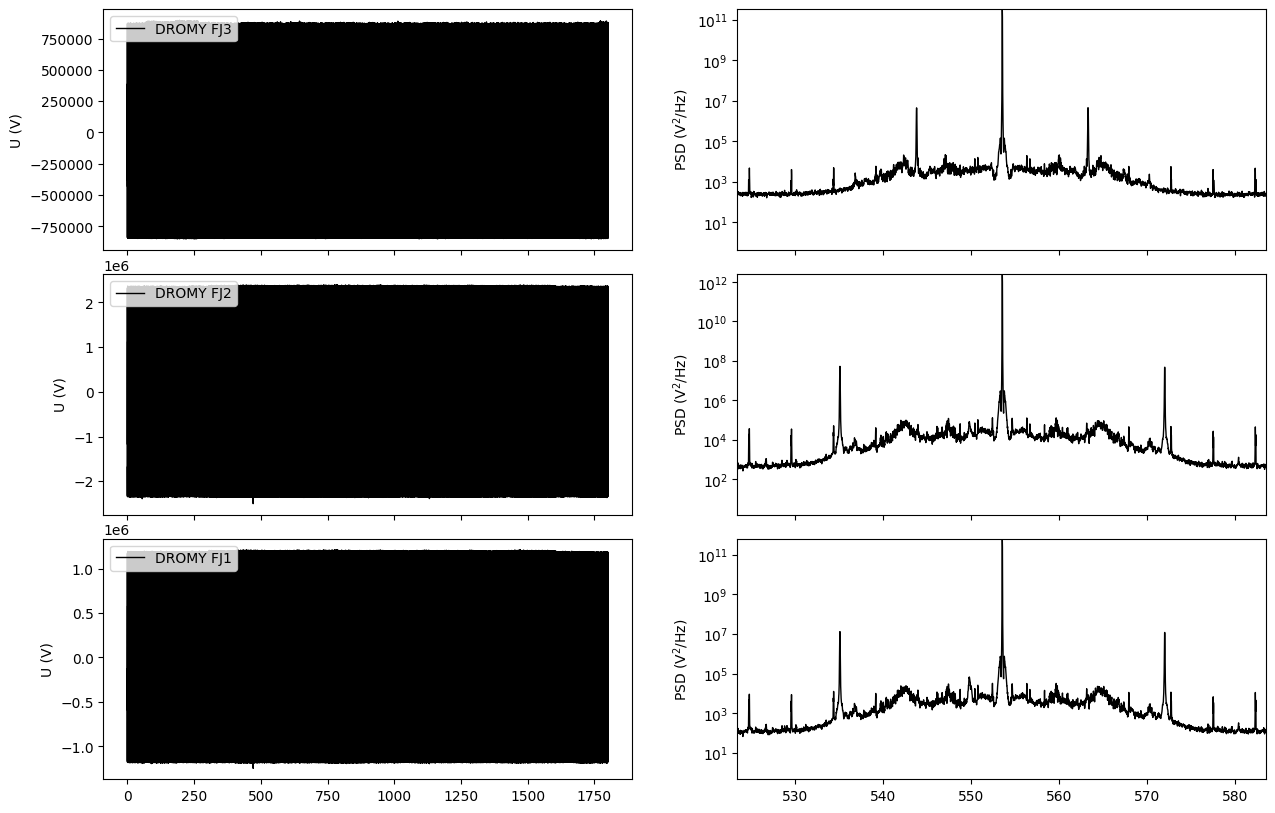

In [32]:
fig, _ = __makeplot_stream_PSD(st, twin_sec=60, f_lower_zoom=config['f_lower_zoomin'], f_upper_zoom=config['f_upper_zoomin'])

# fig.savefig(config['path_to_figs']+f"Prismspectra_Westring_{st[0].stats.starttime.date}_trace&PSD.png", format="png", dpi=150, bbox_inches='tight')


## Plot Comparison

/tmp/ipykernel_776421/223546248.py:73: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 2500)


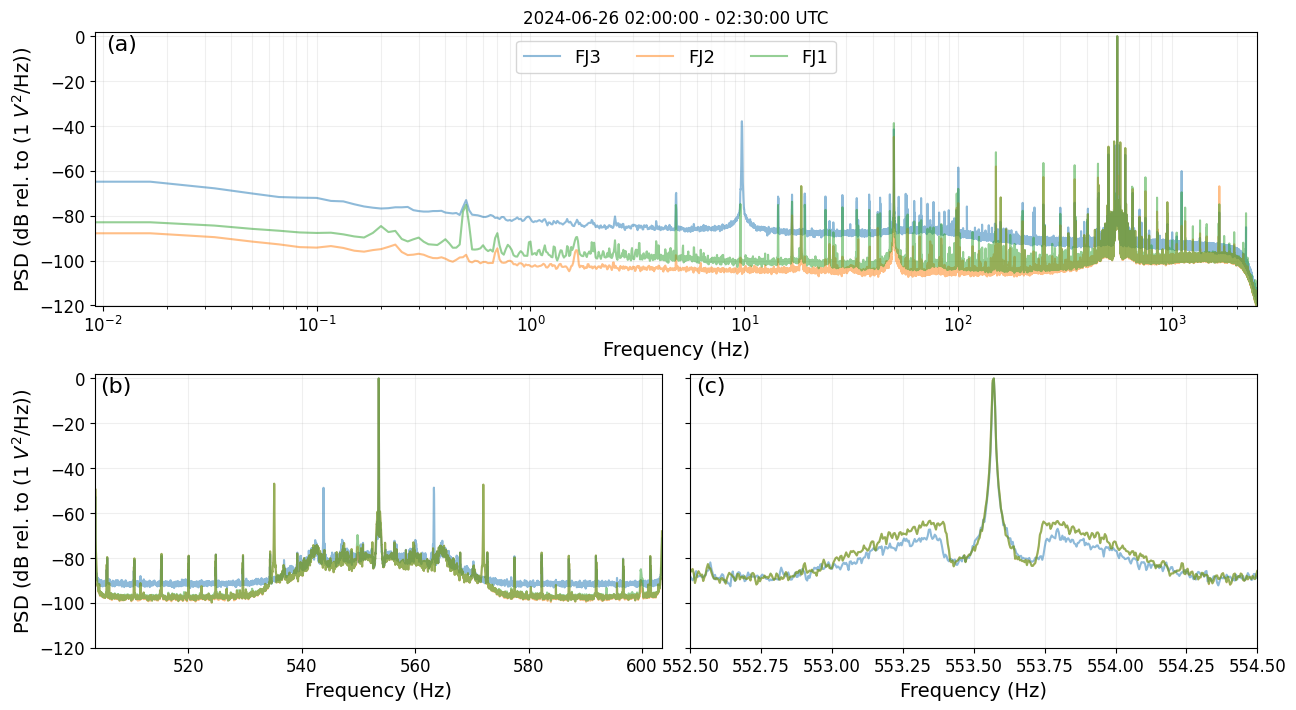

In [33]:
def __makeplot_psd_overview(stx, twin_sec=60, plot_dB=True, norm="individual"):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    font = 14

    f_lower_zoom1 = config['sagnac'][config['ring']] - 50
    f_upper_zoom1 = config['sagnac'][config['ring']] + 50

    f_lower_zoom2 = config['sagnac'][config['ring']] - 1
    f_upper_zoom2 = config['sagnac'][config['ring']] + 1


    stx = stx.detrend("demean")

    out = __compute_psd_array(stx, twin_sec=twin_sec, spec="PSD")
    Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']

    out2 = __compute_psd_array(stx, twin_sec=twin_sec*4, spec="PSD")
    Pxxs2, ffs2, chs2 = out2['Pxxs'], out2['ffs'], out2['chs']

    # chs[0] = chs[0]+f" ({before})"
    # chs[1] = chs[1]+f" ({after})"

    fig = plt.figure(figsize=(15, 8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(2, 2, hspace=0.25)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :1])
    ax3 = fig.add_subplot(gs[1, 1:])


    if plot_dB:
        max_db = []
        for jj in range(len(Pxxs)):
            max_db.append(max(__to_dB(Pxxs[jj])))
    max_max_db = round(max(max_db), 0)


    for jj in range(len(Pxxs)):
        if plot_dB:
            if norm == "individual":
                ax1.plot(ffs[jj], __to_dB(Pxxs[jj])-abs(max(__to_dB(Pxxs[jj]))), alpha=0.5, label=chs[jj])
                ax2.plot(ffs[jj], __to_dB(Pxxs[jj])-abs(max(__to_dB(Pxxs[jj]))), alpha=0.5, label=chs[jj])
                ax3.plot(ffs2[jj], __to_dB(Pxxs2[jj])-abs(max(__to_dB(Pxxs2[jj]))), alpha=0.5, label=chs2[jj])
            else:
                ax1.plot(ffs[jj], __to_dB(Pxxs[jj])-max_max_db, alpha=0.5, label=chs[jj])
                ax2.plot(ffs[jj], __to_dB(Pxxs[jj])-max_max_db, alpha=0.5, label=chs[jj])
                ax3.plot(ffs2[jj], __to_dB(Pxxs2[jj])-max_max_db, alpha=0.5, label=chs2[jj])
            ax1.set_ylim(-100, max_max_db)
            ax2.set_ylim(-100, max_max_db)
        else:
            ax1.loglog(ffs[1], Pxxs[0], alpha=0.5, label=chs[1])
            ax2.loglog(ffs[1], Pxxs[0], alpha=0.5, label=chs[1])
            ax3.loglog(ffs2[1], Pxxs2[0], alpha=0.5, label=chs2[1])

    if norm == "individual":
        ax1.set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
        ax2.set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
    else:
        ax1.set_ylabel(f"PSD (dB rel. to ({max_max_db} $V^2$/Hz))", fontsize=font)
        ax2.set_ylabel(f"PSD (dB rel. to ({max_max_db} $V^2$/Hz))", fontsize=font)

    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)
    ax1.set_xscale("log")
    ax1.set_xlim(0, 2500)

    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)

    ax3.set_xlabel("Frequency (Hz)", fontsize=font)
    ax3.grid(alpha=0.2, which="both")
    ax3.tick_params(labelsize=font-2)
    ax3.set_yticklabels([])


    ax2.set_xlim(f_lower_zoom1, f_upper_zoom1)
    ax3.set_xlim(f_lower_zoom2, f_upper_zoom2)

    ax1.set_ylim(-120, 2)
    ax2.set_ylim(-120, 2)
    ax3.set_ylim(-120, 2)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.01, .99, '(c)', ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)

    time_str1 = f"{stx[0].stats.starttime.date} {str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    time_str2 = f"{stx[1].stats.starttime.date} {str(stx[1].stats.starttime.time).split('.')[0]} - {str(stx[1].stats.endtime.time).split('.')[0]} UTC"

    ax1.set_title(f"{time_str1}")

    plt.show();
    return fig

fig = __makeplot_psd_overview(st, twin_sec=60, plot_dB=True, norm="individual");

fig.savefig(config['path_to_figs']+f"SF_noise_{config['ring']}_comparison2.png", format="png", dpi=150, bbox_inches='tight')
